# **Ultimate Guide to Variational Autoencoders (VAEs) with TensorFlow**

---

## **1. Introduction**

### **What is a Variational Autoencoder (VAE)?**
A **Variational Autoencoder (VAE)** is a generative model that combines principles from deep learning and probabilistic modeling. Unlike traditional autoencoders, VAEs are designed to generate new data by learning a **latent representation** of the input data. They are widely used for tasks like image generation, data compression, and anomaly detection.

### **Key Concepts**
1. **Encoder**: Maps input data to a latent space (mean and variance).
2. **Latent Space**: A lower-dimensional representation of the data.
3. **Decoder**: Reconstructs data from the latent space.
4. **Reparameterization Trick**: Enables gradient-based optimization by sampling from the latent space.

### **Objective**
To build and train a VAE using TensorFlow for **image generation** and understand its underlying principles.

---

## **2. Metadata and Dataset Overview**

### **Dataset Used**
- **Dataset Name**: MNIST
- **Source**: [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/mnist)
- **Description**: A dataset of 28x28 grayscale images of handwritten digits (0-9).

### **Acknowledgement**
This dataset is publicly available and widely used for educational purposes in machine learning.

---

## **3. Technical Concepts**

#### **What Are VAEs?**  
A Variational Autoencoder (VAE) is a type of neural network used for generating new data points similar to a given dataset. Unlike traditional autoencoders, VAEs introduce randomness into the process by learning a distribution over the latent space, making them powerful for tasks like image generation and data augmentation.

---

### **How VAEs Work: Step-by-Step**

#### **1. Encoder (Compression Step)**  
- The encoder takes the input data `x` (e.g., an image) and maps it into a **latent space**.  
- Instead of a fixed representation, the encoder learns two parameters of a **Gaussian distribution** for each input:  
  - The mean (`mu`)  
  - The log variance (`log_sigma_squared`)  

  These parameters define the probability distribution for the latent vector, rather than a single deterministic value.

#### **2. Sampling (Adding Variability)**  
- To introduce randomness and make the latent space smooth, we sample a latent vector `z` from the Gaussian distribution defined by the encoder.  
- This is done using the **reparameterization trick** to allow gradient-based optimization:  
  ```
  z = mu + sigma * epsilon
  ```
  Here:
  - `sigma` is obtained as the square root of `exp(log_sigma_squared)`.
  - `epsilon` is random noise sampled from a standard normal distribution (mean 0, variance 1).

#### **3. Decoder (Reconstruction Step)**  
- The decoder takes the sampled latent vector `z` and attempts to reconstruct the original input `x`.  
- The output of the decoder is a reconstruction `x_hat` that should resemble the input as closely as possible.  

---

### **Loss Function: Optimizing VAEs**

The VAE loss function balances two objectives:  
1. **Reconstruction Loss**: Ensures the reconstructed data `x_hat` is similar to the original data `x`.  
   - Common metrics include **binary cross-entropy (BCE)** or **mean squared error (MSE)**.  
   - Example: For an image, this measures pixel-wise differences between `x` and `x_hat`.  

2. **KL Divergence**: Ensures that the learned latent space distribution is close to a standard Gaussian distribution (mean 0, variance 1).  
   - This acts as a regularization term, preventing overfitting and encouraging smoothness in the latent space.  

The total loss is:  
```
Loss = Reconstruction Loss + KL Divergence
```

#### **KL Divergence Term**  
- Mathematically, KL Divergence measures the difference between two probability distributions:  
  ```
  KL = 0.5 * sum(1 + log_sigma_squared - mu^2 - exp(log_sigma_squared))
  ```
  - `mu` is the mean of the learned distribution.  
  - `log_sigma_squared` is the log of the variance.  
  - The term penalizes deviations from the standard normal distribution.

---

### **Putting It All Together**  
1. **Training Goal**: Minimize the loss by optimizing both the reconstruction quality and the latent space distribution.  
2. **Result**: After training, VAEs can generate new data points by sampling from the latent space and passing them through the decoder.

This process allows VAEs to learn both a compressed representation of the data and a smooth latent space that supports generating diverse, realistic outputs.

---

## **4. Setup and Data Preprocessing**

### **Install Dependencies**


In [1]:
!pip install tensorflow tensorflow-datasets matplotlib

### **Explanation**
- **`tensorflow`**: TensorFlow, a deep learning framework.
- **`tensorflow-datasets`**: Provides access to datasets like MNIST.
- **`matplotlib`**: Used for visualizing images and results.

---

### **Load Dataset**


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load MNIST dataset
(ds_train, ds_test), ds_info = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# Normalize images to [0, 1]
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

# Prepare datasets
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(128).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128).prefetch(tf.data.AUTOTUNE)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### **Explanation**
- **`tfds.load`**: Loads the MNIST dataset.
- **`normalize_img`**: Normalizes pixel values to the range [0, 1].
- **`batch(128)`**: Creates batches of 128 images.
- **`prefetch(tf.data.AUTOTUNE)`**: Optimizes data loading for performance.


## **5. Build the VAE Model**

### **Code: Define the VAE**

In [4]:


from tensorflow.keras import layers, Model

class VAE(Model):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(28, 28, 1)),
            layers.Flatten(),
            layers.Dense(400, activation="relu"),
            layers.Dense(latent_dim + latent_dim),  # Mean and log variance
        ])

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(400, activation="relu"),
            layers.Dense(28 * 28, activation="sigmoid"),
            layers.Reshape((28, 28, 1)),
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar


### **Explanation**
- **Encoder**:
  - `Flatten`: Converts 28x28 images into a 784-dimensional vector.
  - `Dense(400)`: Maps the input to 400 dimensions.
  - `Dense(latent_dim + latent_dim)`: Outputs the mean and log variance of the latent space.
- **Reparameterization Trick**:
  - Samples a latent vector \( z \) using the mean \( \mu \) and log variance \( \log \sigma^2 \).
- **Decoder**:
  - `Dense(400)`: Maps the latent vector back to 400 dimensions.
  - `Dense(28 * 28)`: Reconstructs the input image (784 dimensions).
  - `Reshape`: Converts the output back into a 28x28 image.
- **Forward Pass**:
  - Encodes the input, samples from the latent space, and decodes to reconstruct the input.


### **Code: Define the Loss Function**

In [6]:
def loss_function(recon_x, x, mean, logvar):
    # Reconstruction loss (binary cross-entropy)
    recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, recon_x), axis=[1, 2])

    # KL divergence
    kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=1)

    return tf.reduce_mean(recon_loss + kl_loss)


### **Explanation**
- **Reconstruction Loss**: Measures how well the decoder reconstructs the input image using binary cross-entropy.
- **KL Divergence**: Encourages the latent distribution to be close to a standard Gaussian distribution.
- The total loss is the sum of the reconstruction loss and KL divergence.


## **6. Train the VAE**

### **Code: Training Loop**


In [7]:
# Initialize model and optimizer
vae = VAE()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Training function
@tf.function
def train_step(images):
    with tf.GradientTape() as tape:
        recon_images, mean, logvar = vae(images)
        loss = loss_function(recon_images, images, mean, logvar)
    gradients = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    return loss

# Train for 10 epochs
for epoch in range(1, 11):
    epoch_loss = 0
    for batch in ds_train:
        images, _ = batch
        loss = train_step(images)
        epoch_loss += loss
    print(f"Epoch {epoch}, Loss: {epoch_loss / len(ds_train):.6f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1, Loss: 163.349579
Epoch 2, Loss: 121.785599
Epoch 3, Loss: 115.523781
Epoch 4, Loss: 112.353226
Epoch 5, Loss: 110.414116
Epoch 6, Loss: 109.043434
Epoch 7, Loss: 108.082214
Epoch 8, Loss: 107.350098
Epoch 9, Loss: 106.759346
Epoch 10, Loss: 106.285423


### **Explanation**
- **`tf.function`**: Compiles the training step for faster execution.
- **`GradientTape`**: Records operations for automatic differentiation.
- **`apply_gradients`**: Updates the model parameters using the computed gradients.
- The model is trained for 10 epochs, and the loss is printed after each epoch.


## **7. Generate Images**

### **Code: Generate and Visualize Images**


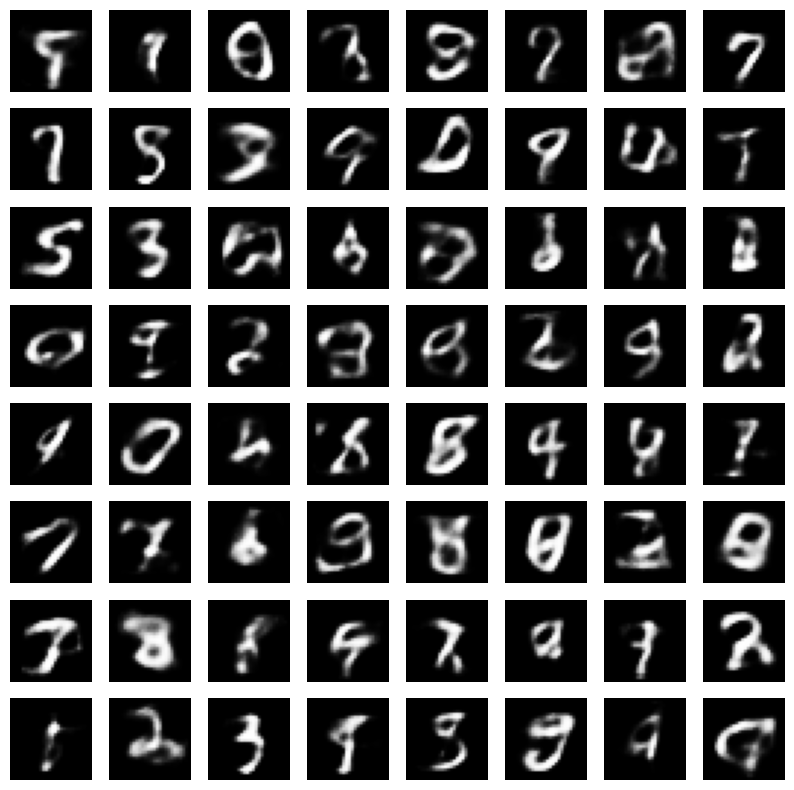

In [8]:
# Generate images
latent_vectors = tf.random.normal(shape=(64, 20))
generated_images = vae.decode(latent_vectors)

# Plot generated images
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[i].numpy().squeeze(), cmap="gray")
    ax.axis("off")
plt.show()


### **Explanation**
- **`tf.random.normal`**: Generates 64 random latent vectors.
- **`vae.decode`**: Decodes the latent vectors into images.
- **Visualization**: Plots the generated images in an 8x8 grid.


## **8. Advantages and Disadvantages**

### **Advantages**
1. **Generative Capability**: Can generate new data samples.
2. **Latent Space**: Provides a meaningful representation of the data.
3. **Probabilistic Framework**: Incorporates uncertainty in the latent space.

### **Disadvantages**
1. **Blurry Outputs**: Generated images may lack sharpness.
2. **Complex Training**: Requires careful tuning of hyperparameters.
3. **Limited Capacity**: May struggle with complex datasets.

---

## **9. Conclusion**

### **Key Learnings**
- VAEs are powerful generative models that learn a probabilistic latent representation of data.
- The reparameterization trick enables gradient-based optimization.
- VAEs can be used for tasks like image generation, data compression, and anomaly detection.

### **Next Steps**
1. **Experiment with Larger Models**: Try deeper architectures or convolutional layers.
2. **Explore Other Datasets**: Apply VAEs to datasets like CIFAR-10 or CelebA.
3. **Improve Output Quality**: Use techniques like VQ-VAE or adversarial training.

---

## **10. References**
- [Auto-Encoding Variational Bayes (Paper)](https://arxiv.org/abs/1312.6114)
- [TensorFlow Documentation](https://www.tensorflow.org/api_docs)
- [MNIST Dataset](https://www.tensorflow.org/datasets/catalog/mnist)

